In [1]:
# stave.py
# G. Cowan / RHUL Physics / August 2021
# Computes Student's t average, with the number of degrees of
# freedom nu related to the relative uncertainty r in the
# standard deviations of the measurements, nu = 1/(2*r**2), see
# G. Cowan, Eur. Phys. J. C (2019) 79 :133, arXiv:1809.05778.
# Uses iminuit version 2.x (not compatible with v 1.x).

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
print(f"iminuit version: {iminuit.__version__}")      #  should be v 2.x

iminuit version: 2.8.2


In [2]:
mu = 10.                                  # initial value for fit
y = np.array([8., 9., 10., 11., 12.])     # measured values
s = np.array([1., 1., 1., 1., 1.])        # estimates of std. dev
v = s**2                                  # estimates of variances
r = np.array([0.2, 0.2, 0.2, 0.2, 0.2])   # relative errors on errors

In [3]:
class NegLogL:

    def __init__(self, y, s, r):
        self.setData(y, s, r)
        
    def setData(self, y, s, r):
        self.data = y, s, r

    def __call__(self, mu):
        y, s, r = self.data
        v = s ** 2
        lnf = -0.5*(1. + 1./(2.*r**2))*np.log(1. + 2.*(r*(y-mu))**2/v)
        return -np.sum(lnf)

In [4]:
# Initialize Minuit and set up fit:
negLogL = NegLogL(y, s, r)          # instantiate function to be minimized
parin     = np.array([mu])          # initial values
parname = ['mu']
parstep = np.array([0.5])           # initial setp sizes
parfix  = [False]                   # change these to fix/free parameters
parlim  = [(None, None)]
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5

In [5]:
# do the fit, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

In [6]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 mu          =  10.000000  +/-  0.525104

free par indices, covariance, correlation coeff.:
0 0 0.275734 1.000000


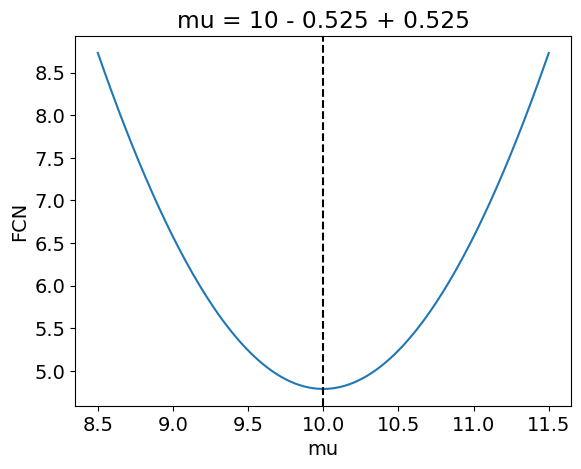

In [7]:
# Make scan of -lnL
if not m.fixed["mu"]:
    plt.figure()
    m.draw_mnprofile('mu', band=False, bound=(8.5, 11.5), size=200)
    plt.show()